In [1]:
from pathlib import Path
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary

In [5]:
import matplotlib.pyplot as plt

In [6]:
import casadi

## Load the existing GP model

In [7]:
df_sampled = pd.read_pickle("gp_trainset.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'gp_trainset.pkl'

In [9]:
x_scaler = pickle.load(open('x_scaler.pkl', 'rb'))

In [10]:
df_input = df_sampled.drop(columns = ['y'])
df_output = df_sampled['y']

In [11]:
np_input = df_input.to_numpy()
np_output = df_output.to_numpy().reshape(-1, 1)

In [12]:
np_input_sc = x_scaler.transform(np_input)

In [13]:
n_states = np_input_sc.shape[1]

In [14]:
k = gpflow.kernels.SquaredExponential(lengthscales=([1] * np_input.shape[1])) + gpflow.kernels.Constant()
print_summary(k)

╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value          │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0            │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ (7,)    │ float64 │ [1., 1., 1.... │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.0            │
╘═════════════════════════════╧═══════════╧═════

In [15]:
model = gpflow.models.GPR(
    data = (np_input_sc, np_output), 
    kernel = k, 
    mean_function = None
    )
print_summary(model)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value          │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0            │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ (7,)    │ float64 │ [1., 1., 1.... │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ Tru

In [16]:
model_params_loaded = pickle.load(open(Path(Path.cwd(), 'gp_params.gpf'), 'rb'))

In [17]:
gpflow.utilities.multiple_assign(model, model_params_loaded)

In [18]:
## Load the test experimental data

In [19]:
def load_autoregressive_df(exp_id, lu = 1, ly = 3):
    
    df_wdb = pd.read_pickle(f"../Data/Experimental_python/Exp{exp_id}_WDB.pkl")
    
    df_carnot = pd.read_pickle(f"../Data/CARNOT_output/Exp{exp_id}_full.pkl")
    df_data = df_carnot.loc[:, ['Power', 'Heat', 'Setpoint', 'OutsideTemp', 'SupplyTemp', 'InsideTemp', 'SolRad']]
    df_simulated = df_carnot.loc[:, 'SimulatedTemp']

    df = pd.concat([df_wdb, df_data.reset_index(), df_simulated.reset_index()], axis = 1)

    df = df.loc[:,~df.columns.duplicated()]
    
    # Select the potentially useful columns
    #df = df.loc[:, ['timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Power', 'InsideTemp', 'SolRad', 'Setpoint']]
    df = df.loc[:, ['timestamp','SolRad', 'OutsideTemp', 'Heat', 'InsideTemp']]

    df.drop(columns = ['timestamp'], inplace = True)
    df.loc[:, 'timestamp'] = df_data.index
    df.set_index('timestamp', drop = True, inplace = True)
    
    # Select the input/output and drop the columns that doesn't make to be used
    dyn_in = 'Heat'
    dyn_out = 'InsideTemp'    
    df.rename(columns = {dyn_in: 'u', dyn_out: 'y'}, inplace = True)

    # Add the regressive inputs/outputs
    for idx in range(1, lu + 1):
        df[f"u_{idx}"] = df['u'].shift(idx)
        
    for idx in range(1, ly + 1):
        df[f"y_{idx}"] = df['y'].shift(idx)
        
    # Since some lines now have holes, drop them
    df.dropna(inplace = True)
    
    return df

In [20]:
test_day = 5 # can be either 3 or 5 since 
df_test = load_autoregressive_df(test_day)
np_test_in = df_test.drop(columns = ['y']).to_numpy()
np_test_in_sc = x_scaler.transform(np_test_in)
np_test_out = df_test['y'].to_numpy().reshape(-1, 1)

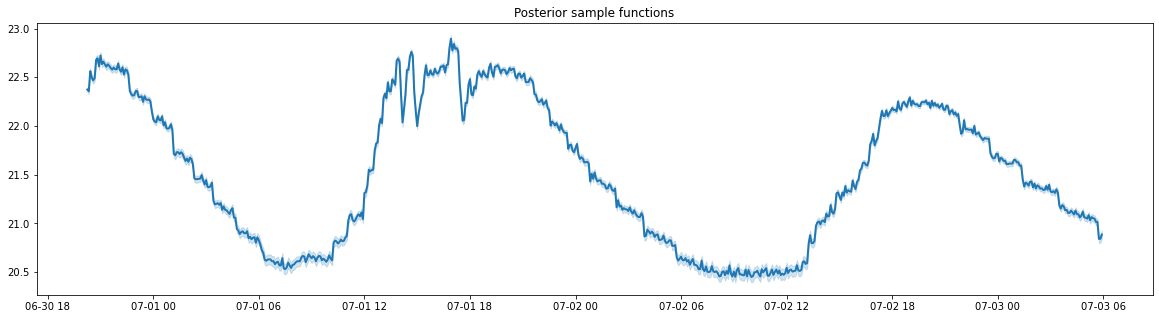

In [21]:
## generate test points for prediction
xx = x_scaler.transform(np_test_in)

## predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(20, 5))
plt.title('Posterior sample functions')
plt.plot(df_test.index, mean, "C0", lw=2)
plt.fill_between(
    df_test.index,
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
#plt.plot(df_test.index, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(df_test.index, np_test_out[:, :], ':', color = 'darkorange', lw = 2)
#_ = plt.ylim(21, 23.5)
plt.show()

In [22]:
# Package the resulting regression model in a CasADi callback
class GPR(casadi.Callback):
  def __init__(self, name,  opts={}):
    casadi.Callback.__init__(self)
    self.construct(name, opts)
    
  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1

  def get_sparsity_in(self,i):
      return casadi.Sparsity.dense(n_states,1)

  def eval(self, arg):
    x_scaled = x_scaler.transform(np.array(arg[0]).reshape(1, -1))
    [mean, _] = model.predict_y(x_scaled)
    return [mean.numpy()]

In [23]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0[7])->(o0) CallbackInternal


In [24]:
## CasADi optimization problem

In [25]:
T_set = 20
N_horizon = 10

## Test area

In [126]:
X = casadi.MX.sym("X", N_horizon, n_states)
W = casadi.MX.sym("W", N_horizon, 2)
x0_lags = casadi.MX.sym("lags", 1, n_states - 3)

In [127]:
# Impose initial lags

In [128]:
g = casadi.vec(X[0,3:] - x0_lags)

In [129]:
# Impose disturbances

In [130]:
g = casadi.vertcat(
    g,
    casadi.vec(X[:, :2] - W)
)

In [131]:
g.shape

(24, 1)

In [132]:
# Calculate objective
J = 0
for idx in range(N_horizon):
    J += casadi.norm_2(gpr(X[0,:]) - T_set)

In [133]:
# Impose lags
for idx in range(1, N_horizon):
    g = casadi.vertcat(
        g,
        X[idx, 3] - X[idx-1, 2],
        X[idx, 4] - gpr(X[idx-1,:]),
        X[idx, 5] - X[idx-1, 4],
        X[idx, 6] - X[idx-1, 5]
    )

In [134]:
g.shape

(60, 1)

In [135]:
# Impose input inequality constraints

In [136]:
g = casadi.vertcat(
    g,
    X[:, 2]
)

In [137]:
g.shape

(70, 1)

In [138]:
J = casadi.norm_2(gpr(X.reshape((N_horizon, -1)).T) - 25)

In [139]:
# Define parameters
p = casadi.vertcat(
    casadi.vec(W),
    casadi.vec(x0_lags)
)

In [140]:
g.shape

(70, 1)

In [141]:
prob = {"x": casadi.vec(X), "f": J, "p": p, "g": g}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 100, 
                    "acceptable_tol": 1e-8, "acceptable_obj_change_tol": 1e-6}}

In [142]:
solver = casadi.nlpsol("solver","ipopt",prob, options)

In [143]:
real_W = casadi.DM(N_horizon, 2)
real_W[:, :] = 2 * np.ones((N_horizon, 2))

In [144]:
real_x0 = casadi.DM(1, 4)
real_x0[:] = [1, 2, 3, 4]

In [145]:
real_p = casadi.vertcat(
    casadi.vec(real_W),
    casadi.vec(real_x0)
)

In [146]:
Pel_max = 6300
COP_heat = 1
COP_cool = 3
u_min = - COP_cool * Pel_max
u_max = COP_heat * Pel_max

In [147]:
real_lbg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_min] * (N_horizon)
real_ubg = [0] * (4 + 2 * N_horizon + 4 * (N_horizon - 1)) + [u_max] * (N_horizon)

In [148]:
res = solver(p = real_p, lbg = real_lbg, ubg = real_ubg)
res['x']

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      150
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       70
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

DM([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, -5276.26, -10771, 4088.54, -4909.72, 5339.09, 6299.99, 6299.8, -14154.4, 4279.15, 599.066, 1, -5276.26, -10771, 4088.54, -4909.72, 5339.09, 6299.99, 6299.8, -14154.4, 4279.15, 2, 12.1019, 16.044, 18.912, 20.1879, 20.6361, 20.8219, 20.8302, 20.7725, 20.3594, 3, 2, 12.1019, 16.044, 18.912, 20.1879, 20.6361, 20.8219, 20.8302, 20.7725, 4, 3, 2, 12.1019, 16.044, 18.912, 20.1879, 20.6361, 20.8219, 20.8302])

In [42]:
res['x']

DM([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3.03502e+07, -2.52271e+07, 2.05064e+07, -4.67068e+07, 9.09586e+07, 3.50245e+07, -1.16515e+08, 1.398e+08, -8.8153e+07, 5.69382e+06, 1, 3.03502e+07, -2.52271e+07, 2.05064e+07, -4.67068e+07, 9.09586e+07, 3.50245e+07, -1.16515e+08, 1.398e+08, -8.8153e+07, 2, 16.4965, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 3, 2, 16.4965, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 4, 3, 2, 16.4965, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653])

In [149]:
res['x'].reshape((N_horizon, -1))

DM(
[[2, 2, -5276.26, 1, 2, 3, 4], 
 [2, 2, -10771, -5276.26, 12.1019, 2, 3], 
 [2, 2, 4088.54, -10771, 16.044, 12.1019, 2], 
 [2, 2, -4909.72, 4088.54, 18.912, 16.044, 12.1019], 
 [2, 2, 5339.09, -4909.72, 20.1879, 18.912, 16.044], 
 [2, 2, 6299.99, 5339.09, 20.6361, 20.1879, 18.912], 
 [2, 2, 6299.8, 6299.99, 20.8219, 20.6361, 20.1879], 
 [2, 2, -14154.4, 6299.8, 20.8302, 20.8219, 20.6361], 
 [2, 2, 4279.15, -14154.4, 20.7725, 20.8302, 20.8219], 
 [2, 2, 599.066, 4279.15, 20.3594, 20.7725, 20.8302]])

In [150]:
gpr(res['x'].reshape((N_horizon, -1)).T)

DM([[12.1019, 16.041, 18.9237, 20.1169, 20.637, 20.8187, 20.8361, 20.7795, 20.3782, 20.2176]])

In [45]:
gpr(res['x'].reshape((N_horizon, -1)).T)

DM([[16.4965, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653, 20.1653]])

In [46]:
# Solve the optimization problem for one time step on real data

In [ ]:
def load_autoregressive_df(exp_id, lu = 1, ly = 3):
    
    df_wdb = pd.read_pickle(f"../Data/Experimental_python/Exp{exp_id}_WDB.pkl")
    
    df_carnot = pd.read_pickle(f"../Data/CARNOT_output/Exp{exp_id}_full.pkl")
    df_data = df_carnot.loc[:, ['Power', 'Heat', 'Setpoint', 'OutsideTemp', 'SupplyTemp', 'InsideTemp', 'SolRad']]
    df_simulated = df_carnot.loc[:, 'SimulatedTemp']

    df = pd.concat([df_wdb, df_data.reset_index(), df_simulated.reset_index()], axis = 1)

    df = df.loc[:,~df.columns.duplicated()]
    
    # Select the potentially useful columns
    #df = df.loc[:, ['timestamp', 'zenith', 'azimuth', 'dni', 'dhi', 'OutsideTemp', 'Power', 'InsideTemp', 'SolRad', 'Setpoint']]
    df = df.loc[:, ['timestamp','SolRad', 'OutsideTemp', 'Heat', 'InsideTemp']]

    df.drop(columns = ['timestamp'], inplace = True)
    df.loc[:, 'timestamp'] = df_data.index
    df.set_index('timestamp', drop = True, inplace = True)
    
    # Select the input/output and drop the columns that doesn't make to be used
    dyn_in = 'Heat'
    dyn_out = 'InsideTemp'    
    df.rename(columns = {dyn_in: 'u', dyn_out: 'y'}, inplace = True)

    # Add the regressive inputs/outputs
    for idx in range(1, lu + 1):
        df[f"u_{idx}"] = df['u'].shift(idx)
        
    for idx in range(1, ly + 1):
        df[f"y_{idx}"] = df['y'].shift(idx)
        
    # Since some lines now have holes, drop them
    df.dropna(inplace = True)
    
    return df

In [78]:
lu, ly = 1, 3
test_day = 3
df_test = load_autoregressive_df(test_day, lu = lu, ly = ly)
df_test

,SolRad,OutsideTemp,u,y,u_1,y_1,y_2,y_3
timestamp,,,,,,,,
2017-06-16 20:15:00+02:00,104.558300,23.0,-12088.862069,22.883333,-12927.931034,23.066667,23.283333,23.166667
2017-06-16 20:20:00+02:00,99.697333,23.0,-20.300000,22.666667,-12088.862069,22.883333,23.066667,23.283333
2017-06-16 20:25:00+02:00,87.216800,23.0,-33.517241,22.650000,-20.300000,22.666667,22.883333,23.066667
2017-06-16 20:30:00+02:00,85.049400,23.0,-33.620690,22.800000,-33.517241,22.650000,22.666667,22.883333
2017-06-16 20:35:00+02:00,77.971900,23.0,-40.241379,22.933333,-33.620690,22.800000,22.650000,22.666667
...,...,...,...,...,...,...,...,...
2017-06-19 05:35:00+02:00,6.040567,18.0,-2.896552,22.300000,-3.000000,22.300000,22.316667,22.316667
2017-06-19 05:40:00+02:00,7.556467,18.0,-3.433333,22.266667,-2.896552,22.300000,22.300000,22.316667
2017-06-19 05:45:00+02:00,9.632667,18.0,-5.448276,22.116667,-3.433333,22.266667,22.300000,22.300000


In [79]:
rand_idx = np.random.randint(0, len(df_test)- N_horizon)

In [151]:
df_slice = df_test.iloc[rand_idx:rand_idx + N_horizon, :]
df_slice

,SolRad,OutsideTemp,u,y,u_1,y_1,y_2,y_3
timestamp,,,,,,,,
2017-06-17 18:10:00+02:00,468.033533,25.0,-6.931034,22.650000,-3531.200000,22.700000,22.700000,22.933333
2017-06-17 18:15:00+02:00,453.411767,25.0,-17.793103,22.966667,-6.931034,22.650000,22.700000,22.700000
2017-06-17 18:20:00+02:00,440.063033,25.0,-10028.379310,23.200000,-17.793103,22.966667,22.650000,22.700000
2017-06-17 18:25:00+02:00,425.747367,25.0,-13186.600000,23.200000,-10028.379310,23.200000,22.966667,22.650000
2017-06-17 18:30:00+02:00,411.838333,25.0,-13120.862069,23.033333,-13186.600000,23.200000,23.200000,22.966667
2017-06-17 18:35:00+02:00,398.560767,25.0,-13122.310345,22.866667,-13120.862069,23.033333,23.200000,23.200000
2017-06-17 18:40:00+02:00,385.483400,25.0,-10483.700000,22.733333,-13122.310345,22.866667,23.033333,23.200000
2017-06-17 18:45:00+02:00,370.694433,25.0,-11.793103,22.683333,-10483.700000,22.733333,22.866667,23.033333
2017-06-17 18:50:00+02:00,357.209133,25.0,-18.310345,22.850000,-11.793103,22.683333,22.733333,22.866667


In [152]:
real_W = df_slice[['SolRad', 'OutsideTemp']].to_numpy()
real_x0 = df_slice.iloc[0,4:].to_numpy()

In [153]:
real_p = casadi.vertcat(
    casadi.vec(real_W),
    casadi.vec(real_x0)
)

In [154]:
res = solver(p = real_p, lbg = real_lbg, ubg = real_ubg)
res['x']

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      150
Number of nonzeros in inequality constraint Jacobian.:       10
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       70
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       60
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       10
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

DM([468.034, 453.412, 440.063, 425.747, 411.838, 398.561, 385.483, 370.694, 357.209, 173.841, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2732.92, 6198.29, -3878.46, 1639.7, 6123.03, -16585.5, 217.313, -14943.5, 6266.88, 49.1826, -3531.2, 2732.92, 6198.29, -3878.46, 1639.7, 6123.03, -16585.5, 217.313, -14943.5, 6266.88, 22.7, 22.7127, 22.9458, 23.1872, 23.5197, 23.7701, 23.6996, 23.6523, 23.7526, 23.9052, 22.7, 22.7, 22.7127, 22.9458, 23.1872, 23.5197, 23.7701, 23.6996, 23.6523, 23.7526, 22.9333, 22.7, 22.7, 22.7127, 22.9458, 23.1872, 23.5197, 23.7701, 23.6996, 23.6523])

In [86]:
res

{'f': DM(4.40448),
 'g': DM([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.00470767, 0, 0, 0, -0.113089, 0, 0, 0, 0.0784758, 0, 0, 0, -0.260693, 0, 0, 0, 0.357126, 0, 0, 0, 0.669296, 0, 0, 0, 0.68248, 0, 0, 0, -0.247434, 0, 0, 0, 0.19414, 0, 0]),
 'lam_g': DM([0.00058908, 3.08326, -0.356412, -0.423444, 0.000371174, 0.000534039, -5.21535e-05, -0.000138734, 5.69737e-05, 5.3783e-05, 0.000187072, 0.000149544, 0.000114475, 3.09363e-06, 0.0420244, 0.0331837, 0.0236642, 0.0183999, 0.0143155, 0.0123639, 0.00744731, 0.00510669, 0.00291009, 0.000884082, 1.91038e-06, 2.43046, -0.265973, -0.332856, 4.74083e-05, 1.82938, -0.195364, -0.246757, 6.22741e-05, 1.35846, -0.15016, -0.180631, -2.68583e-05, 1.08861, -0.120118, -0.138914, -6.83068e-05, 0.917211, -0.0855439, -0.111596, -0.000115542, 0.624076, -0.0576698, -0.0785685, 5.21615e-05, 0.445059, -0.0326176, -0.0531857, 1.60475e-05, 0.237493, -0.0111887, -0.0298096, 6.34075e-06, 0.0680819, -0.000572791, -0.0094662]),
 

In [155]:
df_results = pd.DataFrame(np.array(res['x'].reshape((N_horizon, -1))))
df_results

,0,1,2,3,4,5,6
0,468.033533,25.0,2732.916493,-3531.200000,22.700000,22.700000,22.933333
1,453.411767,25.0,6198.288267,2732.916493,22.712653,22.700000,22.700000
2,440.063033,25.0,-3878.457834,6198.288267,22.945795,22.712653,22.700000
3,425.747367,25.0,1639.701692,-3878.457834,23.187228,22.945795,22.712653
4,411.838333,25.0,6123.032937,1639.701692,23.519734,23.187228,22.945795
5,398.560767,25.0,-16585.507739,6123.032937,23.770119,23.519734,23.187228
6,385.483400,25.0,217.313208,-16585.507739,23.699578,23.770119,23.519734
7,370.694433,25.0,-14943.460194,217.313208,23.652328,23.699578,23.770119
8,357.209133,25.0,6266.876146,-14943.460194,23.752610,23.652328,23.699578
9,173.840733,25.0,49.182629,6266.876146,23.905214,23.752610,23.652328


In [2]:
np.array(res['x'].reshape((N_horizon, -1)))

NameError: name 'np' is not defined